# Construct a binary tree from sklearn decision tree classifier

Sklearn decision trees store their trees as preorder depth first searches. To illustrate how to construct a hierarchical object that can be saved as JSON and loaded to D3, we can look at a simple dataset as the iris.

In [1]:
from sklearn.datasets import load_iris
from sklearn import tree
import graphviz
import json
iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf = clf.fit(iris.data, iris.target)

The results are stored in 

In [2]:
clf.tree_.feature

array([ 3, -2,  3,  2,  3, -2, -2,  3, -2,  2, -2, -2,  2,  1, -2, -2, -2])

or here 

In [3]:
clf.tree_.__getstate__()['nodes']

array([( 1,  2,  3,  0.80000001,  0.66666667, 150,  150.),
       (-1, -1, -2, -2.        ,  0.        ,  50,   50.),
       ( 3, 12,  3,  1.75      ,  0.5       , 100,  100.),
       ( 4,  7,  2,  4.94999981,  0.16803841,  54,   54.),
       ( 5,  6,  3,  1.6500001 ,  0.04079861,  48,   48.),
       (-1, -1, -2, -2.        ,  0.        ,  47,   47.),
       (-1, -1, -2, -2.        ,  0.        ,   1,    1.),
       ( 8,  9,  3,  1.54999995,  0.44444444,   6,    6.),
       (-1, -1, -2, -2.        ,  0.        ,   3,    3.),
       (10, 11,  2,  5.44999981,  0.44444444,   3,    3.),
       (-1, -1, -2, -2.        ,  0.        ,   2,    2.),
       (-1, -1, -2, -2.        ,  0.        ,   1,    1.),
       (13, 16,  2,  4.85000038,  0.04253308,  46,   46.),
       (14, 15,  1,  3.0999999 ,  0.44444444,   3,    3.),
       (-1, -1, -2, -2.        ,  0.        ,   2,    2.),
       (-1, -1, -2, -2.        ,  0.        ,   1,    1.),
       (-1, -1, -2, -2.        ,  0.        ,  43,   43.

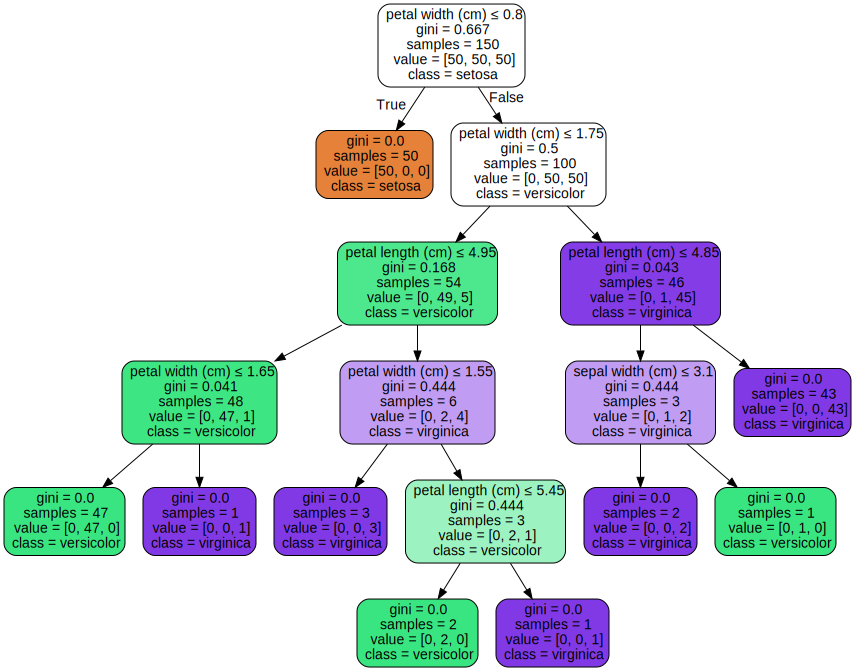

In [4]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## tree construction

We can reconstruct the decision tree by using stacks. Alternatively, we could us recursios.

In [5]:
from collections import deque

class Node:
    
    def __init__(self, name):
        self.name = name
    
    def add_child(self, child):
        self.children = child

# data for reconstructing the tree
features = clf.tree_.feature
feature_names = iris.feature_names

# set containers
leaves = deque()
nodes = []

# count the leaf nodes in the tree in order to return a little bit nicer formatted output
n_leaf = sum([feature == -2 for feature in features])

# build the tree in a bottom-up approach
for feature in reversed(features):
    # if it is a leaf node, append it to leaves and give it a name
    if feature == -2:
        leaves.append('leaf_' + str(n_leaf))
        n_leaf -= 1
    # if it is a node, append it to the tree
    else:
        nodes.append(feature)
        # add left and right children to the stack
        child1=leaves.pop()
        child2=leaves.pop()
        # temporary stack to store the children
        temp_leaves = []
        # and the nodes 
        temp_node_leaves = {}
        temp_leaves.append(child1)
        temp_leaves.append(child2)
        temp_node_leaves[feature_names[feature]] = temp_leaves
        leaves.append(temp_node_leaves)
reconstructed_tree = temp_node_leaves
reconstructed_tree

{'petal width (cm)': ['leaf_1',
  {'petal width (cm)': [{'petal length (cm)': [{'petal width (cm)': ['leaf_2',
        'leaf_3']},
      {'petal width (cm)': ['leaf_4',
        {'petal length (cm)': ['leaf_5', 'leaf_6']}]}]},
    {'petal length (cm)': [{'sepal width (cm)': ['leaf_7', 'leaf_8']},
      'leaf_9']}]}]}

It is a bit difficult to see the hierarchy but by using identation, we can make it a bit more apparent. I believe this is the same data structure that D3 uses for a tree layout.

In [6]:
# depth: 1
{'petal width (cm)': 
    # depth: 2, left child
    ['leaf_1',
    # depth: 2, right child
    {'petal width (cm)': 
         # depth: 3, left child
        [{'petal length (cm)': 
              # depth: 4, left child
            [{'petal width (cm)': 
                  # depth: 5 left child and right children
                ['leaf_2','leaf_3']},
              # depth: 4, right child
            {'petal width (cm)': 
                 # depth: 5, left child
                ['leaf_4',
                 # depth: 5, right child
                {'sepal length (cm)': 
                     # depth: 6, left and right children
                     ['leaf_5', 'leaf_6']}]}]},
         # depth: 3, right child
        {'petal length (cm)': 
            [{'sepal width (cm)': 
                ['leaf_7', 'leaf_8']},
            'leaf_9']}]}]}

{'petal width (cm)': ['leaf_1',
  {'petal width (cm)': [{'petal length (cm)': [{'petal width (cm)': ['leaf_2',
        'leaf_3']},
      {'petal width (cm)': ['leaf_4',
        {'sepal length (cm)': ['leaf_5', 'leaf_6']}]}]},
    {'petal length (cm)': [{'sepal width (cm)': ['leaf_7', 'leaf_8']},
      'leaf_9']}]}]}

or print it out as a JSON

In [7]:
print(json.dumps(reconstructed_tree, indent=4)) 

{
    "petal width (cm)": [
        "leaf_1",
        {
            "petal width (cm)": [
                {
                    "petal length (cm)": [
                        {
                            "petal width (cm)": [
                                "leaf_2",
                                "leaf_3"
                            ]
                        },
                        {
                            "petal width (cm)": [
                                "leaf_4",
                                {
                                    "petal length (cm)": [
                                        "leaf_5",
                                        "leaf_6"
                                    ]
                                }
                            ]
                        }
                    ]
                },
                {
                    "petal length (cm)": [
                        {
                            "sepal width (cm)": [
                 

and store it

In [11]:
with open('../data/tree.json', 'w') as fp:
    json.dump(reconstructed_tree, fp, indent = 4)

In [17]:
from collections import deque

# it is currently superfluous to have a node class but might be useful in the future
class Node:
    
    COUNTER = 0
    
    def __init__(self, name):
        self.name = name
        self.children = []
        Node.COUNTER += 1
    
    def add_child(self, child):
        self.children.append(child)

# data for reconstructing the tree
features = clf.tree_.feature
feature_names = iris.feature_names

# set containers
leaves = deque()
nodes = []

# count the leaf nodes in the tree in order to return a little bit nicer formatted output
n_leaf = sum([feature == -2 for feature in features])

# build the tree in a bottom-up approach
for feature in reversed(features):
    # if it is a leaf node, append it to leaves and give it a name
    if feature == -2:
        leaf = {'name': 'leaf' + str(n_leaf)}
        leaves.append(leaf)
        n_leaf -= 1
    # if it is a node, append it to the tree
    else:
  #      node = Node(feature_names[feature])
  #      print(node.COUNTER)
  #      nodes.append(node)
        # add left and right children to the stack
        child1=leaves.pop()
        child2=leaves.pop()
        # temporary stack to store the children
        temp_leaves = []
        # and the nodes 
        temp_node_leaves = {'name': feature_names[feature]}
        temp_leaves.append(child1)
        temp_leaves.append(child2)
        temp_node_leaves['children'] = temp_leaves
        leaves.append(temp_node_leaves)
reconstructed_tree = temp_node_leaves
reconstructed_tree

{'children': [{'name': 'leaf1'},
  {'children': [{'children': [{'children': [{'name': 'leaf2'},
        {'name': 'leaf3'}],
       'name': 'petal width (cm)'},
      {'children': [{'name': 'leaf4'},
        {'children': [{'name': 'leaf5'}, {'name': 'leaf6'}],
         'name': 'petal length (cm)'}],
       'name': 'petal width (cm)'}],
     'name': 'petal length (cm)'},
    {'children': [{'children': [{'name': 'leaf7'}, {'name': 'leaf8'}],
       'name': 'sepal width (cm)'},
      {'name': 'leaf9'}],
     'name': 'petal length (cm)'}],
   'name': 'petal width (cm)'}],
 'name': 'petal width (cm)'}

In [18]:
print(json.dumps(reconstructed_tree, indent=4)) 

{
    "name": "petal width (cm)",
    "children": [
        {
            "name": "leaf1"
        },
        {
            "name": "petal width (cm)",
            "children": [
                {
                    "name": "petal length (cm)",
                    "children": [
                        {
                            "name": "petal width (cm)",
                            "children": [
                                {
                                    "name": "leaf2"
                                },
                                {
                                    "name": "leaf3"
                                }
                            ]
                        },
                        {
                            "name": "petal width (cm)",
                            "children": [
                                {
                                    "name": "leaf4"
                                },
                                {
                     

In [19]:
with open('../data/tree.json', 'w') as fp:
    json.dump(reconstructed_tree, fp, indent = 4)